In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

In [3]:
val_size = 10000
train_size = len(dataset) - val_size 
train_ds , val_ds = random_split(dataset , [train_size,val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size = 128

In [5]:
train_loader = DataLoader(train_ds, batch_size , shuffle=True, num_workers=4 ,pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4 , pin_memory=True)
test_loader = DataLoader(test_dataset , batch_size*2 , batch_size*2 , num_workers=4 , pin_memory= True)


images.shape: torch.Size([128, 1, 28, 28])
images.shape: torch.Size([128, 1, 28, 28])


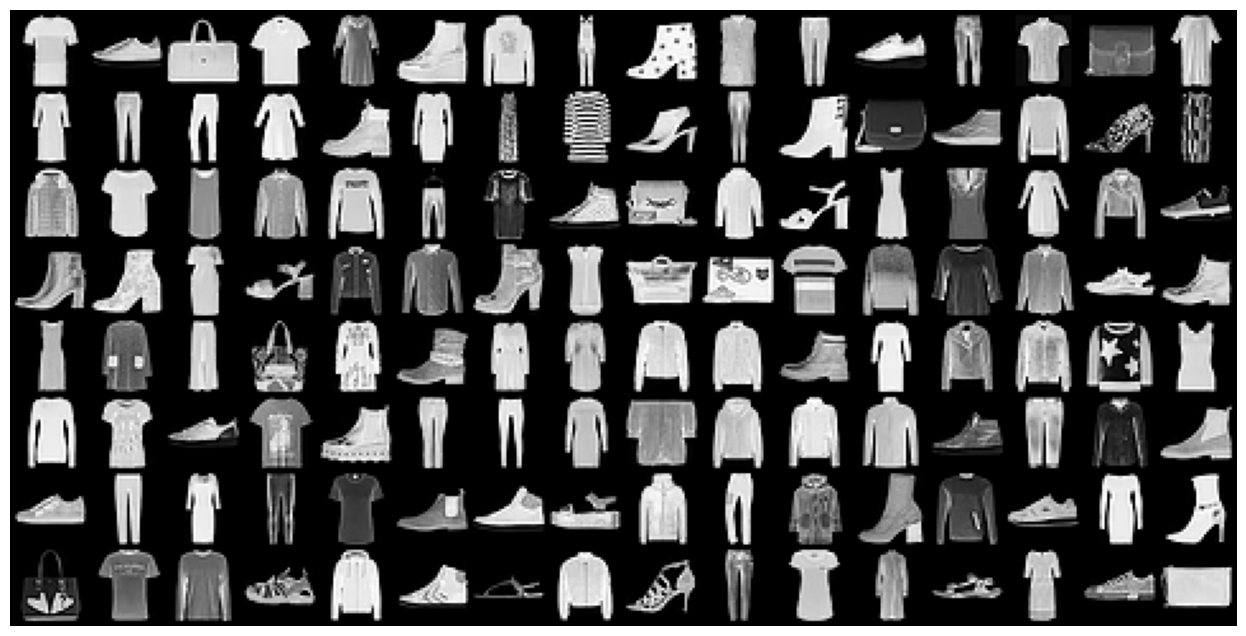

In [6]:
for images , _ in train_loader:
    print('images.shape:',images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    print('images.shape:',images.shape)
    break

Model

In [7]:
def accuracy(outputs , labels):
    _,preds  = torch.max(outputs, dim=1)
    # print(_," ",preds)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class MnistModel(nn.Module):
    """Feedword neural network with 2 hidden layers"""
    def __init__(self, in_size , out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size , 64)
        #hidden layer 2 
        self.linear2 = nn.Linear(64 , 32)
        # output layer 
        self.linear3 = nn.Linear(32, out_size)

    def forward(self , xb):
        #Flatten the image tensors
        out = xb.view(xb.size(0),-1)
        # Get results using hidden layer
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get results using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)           # Generate predictions
        loss = F.cross_entropy(out , labels) # Calculate loss
        return loss
    
    def validation_step(self,batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out , labels)
        return {'val_loss':loss,'val_acc':acc}
    
    def validation_epoch_end(self , outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch , result):
        print("Epoch [{}], val_loss: {:.4f} , val_acc: {:.4f}".format(epoch, result['val_loss'],result['val_acc']))

GPU

In [9]:
torch.cuda.is_available()

True

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
def to_device(data , device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [13]:
class DeviceDataLoader():
    def __init__(self,dl , device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
        
    def __len__(self):
        return len(self.dl)

In [14]:
train_loader = DeviceDataLoader(train_loader , device)
val_loader = DeviceDataLoader(val_loader,device)
test_loader = DeviceDataLoader(test_loader, device)

Training


In [15]:
def evaluate(model , val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs , lr , model , train_loader , val_loader, opt_func = torch.optim.SGD):
    history=[]
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validation Phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch , result)
        history.append(result)
    return history

In [16]:
input_size = 784
num_classes = 10

In [17]:
model = MnistModel(input_size,out_size=num_classes)
to_device(model , device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
history = [evaluate(model,val_loader)]
history

[{'val_loss': 2.307711362838745, 'val_acc': 0.09599609673023224}]

In [19]:
history+= fit(4, 0.5 , model , train_loader , val_loader)

Epoch [0], val_loss: 0.5722 , val_acc: 0.7875
Epoch [1], val_loss: 0.5396 , val_acc: 0.7955
Epoch [2], val_loss: 0.4748 , val_acc: 0.8255
Epoch [3], val_loss: 0.4360 , val_acc: 0.8386


In [20]:
history += fit(4,0.01 , model , train_loader, val_loader)

Epoch [0], val_loss: 0.3743 , val_acc: 0.8594
Epoch [1], val_loss: 0.3703 , val_acc: 0.8615
Epoch [2], val_loss: 0.3682 , val_acc: 0.8621
Epoch [3], val_loss: 0.3667 , val_acc: 0.8615


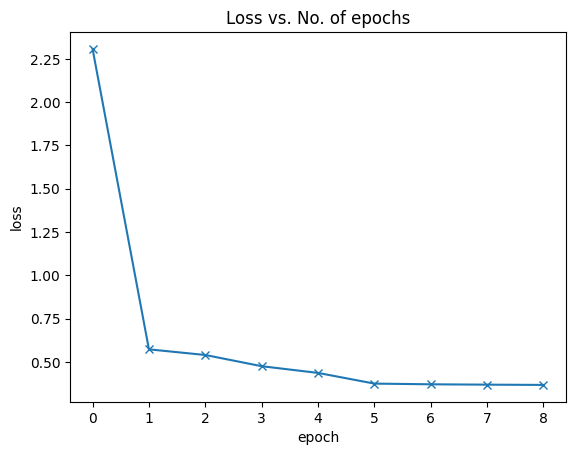

In [21]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

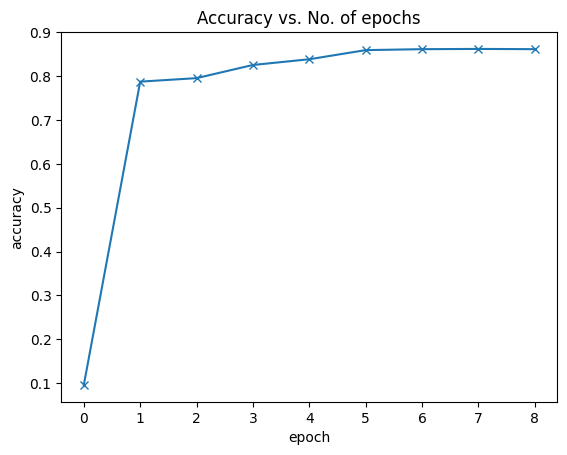

In [22]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [25]:
def predict_images(img, model):
    xb = to_device(img.unsqueeze(0) , device)
    yb = model(xb)
    _ , preds = torch.max(yb , dim = 1)
    return preds[0].item()

Label: Ankle boot ,Predicted: Ankle boot


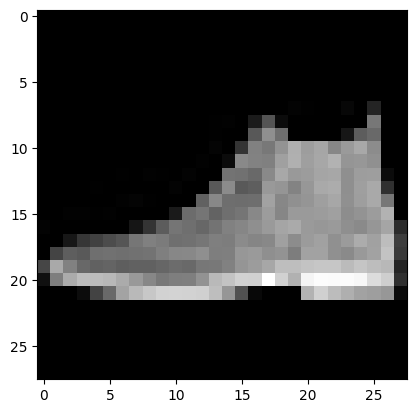

In [26]:
img , label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print('Label:',dataset.classes[label],',Predicted:',dataset.classes[predict_images(img,model)])

In [30]:
import random

In [1]:
img , label = test_dataset[random.randint(0,10000)]
plt.imshow(img[0], cmap = 'gray')
print('Label:',dataset.classes[label],',Predicted:',dataset.classes[predict_images(img,model)])

NameError: name 'test_dataset' is not defined